In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import scipy.signal
import sklearn.linear_model
import xgboost
import pyts
%matplotlib inline

# Fast AI Time Series Competition No1: Earthquakes.

Data is already downloaded in `../data/`. This notebook is mostly exploratory - trying a couple of baseline models.

## Data Loading

In [2]:
data_path = pathlib.Path('../data')

In [3]:
os.listdir(data_path)

['Earthquakes_TEST.txt',
 'Earthquakes_TRAIN.txt',
 'Earthquakes_TRAIN.arff',
 'Earthquakes.txt',
 'Earthquakes_TEST.arff']

In [4]:
train = np.loadtxt(data_path/'Earthquakes_TRAIN.txt')
test = np.loadtxt(data_path/'Earthquakes_TEST.txt')

In [5]:
train, train_labels = train[:, 1:], train[:, 0].astype(np.int)
test, test_labels = test[:, 1:], test[:, 0].astype(np.int)

We've now nicely numpified our data. Let's try a couple of very simple models.

In [6]:
def test_accuracy(predictions):
    return np.mean(test_labels == predictions)

def pretty_result(result, method):
    print("Accuracy of {0}: {1:.4f}".format(method, result))
    
    
def normalize_features(features):
    train_mean = np.mean(train)
    train_std = np.std(train)
    return (features - train_mean)/train_std

## Constant Models:

In [7]:
pretty_result(test_accuracy(np.ones_like(test_labels)), "all trues")
pretty_result(test_accuracy(np.zeros_like(test_labels)), "all falses")

Accuracy of all trues: 0.2518
Accuracy of all falses: 0.7482


## Spectral Features + Logistic Regression

Here we extract the power spectrum, split naively in equal frequency ranges, then run a basic logistic regression classifier.

In [8]:
nperseg = 64
freqs, power = scipy.signal.welch(train[0], nperseg=nperseg)
len(freqs)

33

In [9]:
train_features = np.zeros((len(train), len(freqs)))
test_features = np.zeros((len(test), len(freqs)))

In [10]:
for i, train_serie in enumerate(train):
    freqs, power = scipy.signal.welch(train_serie, nperseg= nperseg)
    train_features[i] = power
    
for i, test_serie in enumerate(test):
    freqs, power = scipy.signal.welch(test_serie, nperseg= nperseg)
    test_features[i] = power

In [11]:
logreg = sklearn.linear_model.LogisticRegression(C=0.1, class_weight="balanced").fit(train_features, train_labels)

/Users/henripal/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
pretty_result(logreg.score(test_features, test_labels), "logistic regression on spectral features")

Accuracy of logistic regression on spectral features: 0.6187


## Spectral Features + xgboost 

Based on the same features above, we run xgboost

In [138]:
def run_xgboost(params, n_round, train_features, train_labels, test_features, test_labels, method="", thresh=.5):
    dtrain = xgboost.DMatrix(train_features, train_labels)
    dtest = xgboost.DMatrix(test_features, test_labels)
    bst = xgboost.train(param, dtrain, num_round)
    preds = bst.predict(dtest)
    predictions = (bst.predict(dtest) > thresh).astype(int)
    pretty_result(test_accuracy(predictions), "xgboost on " + method)

In [ ]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

In [139]:
run_xgboost(param, 2, train_features, train_labels, test_features, test_labels, "spectral features")

Accuracy of xgboost on spectral features: 0.7410


## Time features + xgboost

Based on the raw time features above, we run xgboost

In [141]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'gamma':0,
         'min-child_weight': 0.1,
         'max_delta_step': 0,
         'objective':'binary:logistic' }

In [142]:
run_xgboost(param, 2, normalize_features(train), train_labels, normalize_features(test), test_labels, "time features")

Accuracy of xgboost on time features: 0.7554


## PyTS experiments

In [145]:
pyts_scaler = pyts.preprocessing.StandardScaler()

In [146]:
normalized_train = pyts_scaler.fit_transform(train)
normalized_test = pyts_scaler.transform(test)

Let's try the NLP-like transforms available in pyts and slap xgboost on top:
### Boss:

In [241]:
boss = pyts.transformation.BOSS(4, 128)
boss.fit(train, train_labels)
boss_train = boss.transform(train)
boss_test = boss.transform(test)
boss_train.shape


(322, 256)

In [242]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'gamma':0,
         'min-child_weight': 0.1,
         'max_delta_step': 0,
         'objective':'binary:logistic' }

In [243]:
run_xgboost(param, 4, boss_train, train_labels, boss_test, test_labels, "boss features")

Accuracy of xgboost on boss features: 0.7194


### WEASEL:

In [285]:
weasel = pyts.transformation.WEASEL(2, window_sizes=[12, 24, 36], pvalue_threshold=.3)
weasel.fit(train, train_labels)
weasel_train = weasel.transform(train)
weasel_test = weasel.transform(test)
weasel_train.shape

(322, 42)

Text(0, 0.5, 'Frequencies')

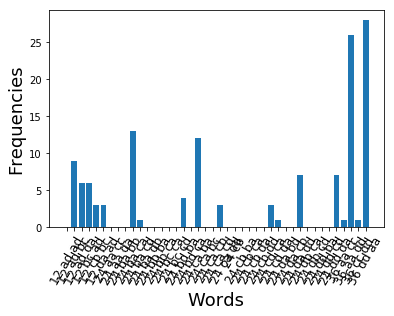

In [286]:
weasel_vec = weasel_train.toarray()[1]
plt.bar(np.arange(weasel_vec.size), weasel_vec)
plt.xticks(np.arange(weasel_vec.size),
           np.vectorize(weasel.vocabulary_.get)(np.arange(weasel_vec.size)),
           fontsize=12, rotation=60)
plt.xlabel("Words", fontsize=18)
plt.ylabel("Frequencies", fontsize=18)

In [287]:
param = {'max_depth':5, 'eta':.3, 'silent':1, 'gamma':1,
         'min-child_weight': 0.8,
         'max_delta_step': 1,
         'objective':'binary:logistic' }
run_xgboost(param, 3, weasel_train, train_labels, weasel_test, test_labels, "weasel features")

Accuracy of xgboost on weasel features: 0.7626


### PyTS classifiers:
We've seen that xgboost on the NLP features didn't perform very well. Let's try the SAX and Boss classifiers from pyts:

In [200]:
sax_classifier = pyts.classification.SAXVSMClassifier(n_bins=2, window_size=8)
sax_classifier.fit(normalized_train, train_labels)
pretty_result(sax_classifier.score(normalized_test, test_labels), "SAX")

/Users/henripal/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/Users/henripal/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


Accuracy of SAX: 0.7482


In [220]:
boss_classifier = pyts.classification.BOSSVSClassifier(8, 128)
boss_classifier.fit(normalized_train, train_labels)
preds = boss_classifier.predict(normalized_test)
pretty_result(test_accuracy(preds), "BOSSVS classifier")

Accuracy of BOSSVS classifier: 0.7554
